In [ ]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [2]:
# Load data
path_omr            = 'C:/Users/Andrew Chen/Desktop/MIMIC Project/MIMIC-IV v2.2/hosp/omr.csv'
df_omr              = pd.read_csv(path_omr)

In [3]:
# Convert data into floats
df_omr['chartdate'] = pd.to_datetime(df_omr['chartdate'])
df_omr['chartdate'] = df_omr['chartdate'].apply(lambda x: x.timestamp())

# Keep only the most recent result for each patient
df_omr = df_omr.sort_values(by=['subject_id', 'result_name', 'chartdate'], ascending=[True, True, False])
df_omr = df_omr.drop_duplicates(subset=['subject_id', 'result_name'], keep='first')

In [4]:
# Pivot the table such that each row is a patient and each column is a measurement
pivot_values_df = df_omr.pivot_table(
    index='subject_id',
    columns='result_name',
    values='result_value',
    aggfunc='first'
).reset_index()
pivot_dates_df = df_omr.pivot_table(
    index='subject_id',
    columns='result_name',
    values='chartdate',
    aggfunc='first'
).reset_index()

pivot_dates_df = pivot_dates_df.add_suffix('_date')
pivot_dates_df.rename(columns={'subject_id_date': 'subject_id'}, inplace=True)
df = pd.merge(pivot_values_df, pivot_dates_df, on='subject_id')

In [5]:
# Drop columns with more than 20% missing values
missing_values = df.isnull().sum() / len(df)
columns_to_drop = missing_values[missing_values > 0.2].index
df = df.drop(columns=columns_to_drop)

In [6]:
# Drop the entries where Weight or BP is missing
df = df.dropna(subset=['Weight (Lbs)'])
df = df.dropna(subset=['Blood Pressure'])
df = df.dropna(subset=['Height (Inches)'])

In [7]:
# Split blood pressure column into systolic and diastolic columns
df['Systolic BP'] = df['Blood Pressure'].apply(lambda x: x.split('/')[0])
df['Diastolic BP'] = df['Blood Pressure'].apply(lambda x: x.split('/')[1])
df.drop(columns=['Blood Pressure'], inplace=True)

In [8]:
# Convert selected numerical columns to float
numerical_columns = ['Weight (Lbs)', 'Weight (Lbs)_date', 'Systolic BP', 'Diastolic BP', 'Blood Pressure_date', 'Height (Inches)_date', 'Height (Inches)']
df[numerical_columns] = df[numerical_columns].astype(float)

In [9]:
# Feed data into XGBoost to use weight, blood pressure, and date to predict height
X = df[['Weight (Lbs)', 'Weight (Lbs)_date', 'Systolic BP', 'Diastolic BP', 'Blood Pressure_date', 'Height (Inches)_date']]
# X = df[['Weight (Lbs)', 'Systolic BP', 'Diastolic BP']]
y = df['Height (Inches)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = []

# Linear Regression
models.append(('Linear Regression', LinearRegression()))

# XGBoost
models.append(('XGBoost', XGBRegressor()))

# Random Forest
models.append(('Random Forest', RandomForestRegressor(n_estimators=10)))

for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{model_name} MAE: {mae}, MSE: {mse}, R^2: {r2}')

Linear Regression MAE: 2.93323215025246, MSE: 16.65731073317337, R^2: 0.15803184766062595
XGBoost MAE: 3.018090273385444, MSE: 39.96326970747287, R^2: -1.0200019616630391
Random Forest MAE: 3.130802551895307, MSE: 19.385143440969202, R^2: 0.02014955071219071


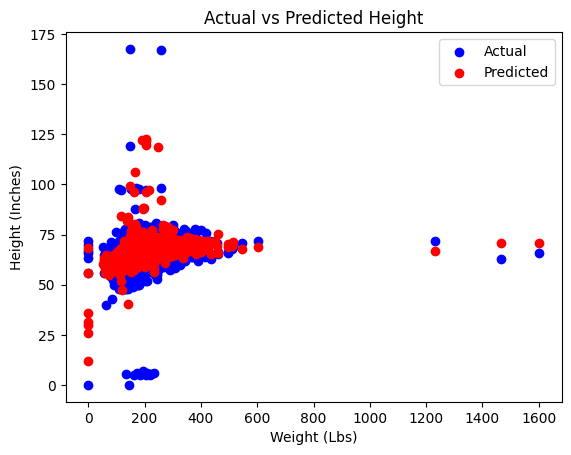

In [10]:
# Plot the actual data
plt.scatter(X_test['Weight (Lbs)'], y_test, color='blue', label='Actual')

# Plot the predicted values
plt.scatter(X_test['Weight (Lbs)'], y_pred, color='red', label='Predicted')

# Add labels and title
plt.xlabel('Weight (Lbs)')
plt.ylabel('Height (Inches)')
plt.title('Actual vs Predicted Height')

# Add legend
plt.legend()

# Show plot
plt.show()

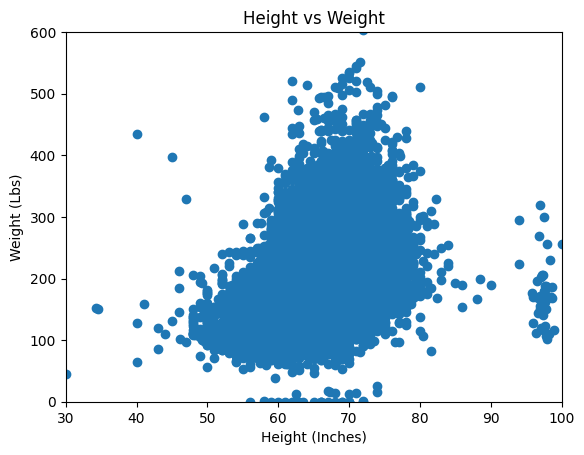

In [11]:
# Select the "Height (Inches)" and "Weight (Lbs)" columns from df
height = df["Height (Inches)"]
weight = df["Weight (Lbs)"]

# Create the bar graph
plt.scatter(height, weight)

# Set the labels and title
plt.xlabel("Height (Inches)")
plt.ylabel("Weight (Lbs)")
plt.title("Height vs Weight")

plt.xlim(30, 100)
plt.ylim(0, 600)

# Display the graph
plt.show()